## Background

A job shop consists of a set of distinct machines that process jobs. Each job is a series of tasks that require use of particular machines for known durations, and which must be completed in specified order. The job shop scheduling problem is to schedule the jobs on the machines to minimize the time necessary to process all jobs (i.e, the makespan) or some other metric of productivity. Job shop scheduling is one of the classic problems in Operations Research. 

Data consists of two tables. The first table is decomposition of the jobs into a series of tasks. Each task lists a job name, name of the required machine, and task duration. The second table list task pairs where the first task must be completed before the second task can be started. This formulation is quite general, but can also specify situations with no feasible solutions.  

## Job shop example

The following example of a job shop is from from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Dash Optimization, 2000.

In this example, there are three printed paper products that must pass through color printing presses in a particular order. The given data consists of a flowsheet showing the order in which each job passes through the color presses

![jobshopdiagram.jpg](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/jobshopdiagram.jpg?raw=1)

and a table of data showing, in minutes, the amount of time each job requires on each machine.

| Machine | Color | Paper 1 | Paper 2 | Paper 3 |
| :-----: | :---: | :-----: | :-----: | :-----: |
| 1       | Blue  | 45      | 20      | 12      |
| 2       | Green | -       | 10      | 17      |
| 3       | Yellow| 10      | 34      | 28      |

What is the minimum amount of time (i.e, what is the makespan) for this set of jobs?

## 4.3.4 Task decomposition

The first step in the analysis is to decompose the process into a series of tasks. Each task is a (job,machine) pair. Some tasks cannot start until a prerequisite task is completed.

| Task (Job,Machine) | Duration | Prerequisite Task |
| :----------------: | :------: | :---------------: |
| (Paper 1, Blue)    | 45       | -                 |
| (Paper 1, Yellow)  | 10       | (Paper 1,Blue)    |
| (Paper 2, Blue)    | 20       | (Paper 2, Green)  |
| (Paper 2, Green)   | 10       | -                 |
| (Paper 2, Yellow)  | 34       | (Paper 2, Blue)   |
| (Paper 3, Blue)    | 12       | (Paper 3, Yellow) |
| (Paper 3, Green)   | 17       | (Paper 3, Blue)   |
| (Paper 3, Yellow)  | 28       | -                 |

We convert this to a JSON style representation where tasks are denoted by (Job,Machine) tuples in Python. The task data is stored in a Python dictionary indexed by (Job,Machine) tuples. The task data conists of a dictionary with duration ('dur') and (Job,Machine) pair for any prerequisite task.

In [ ]:
TASKS = {
    ('Paper_1','Blue')   : {'dur': 45, 'prec': None},
    ('Paper_1','Yellow') : {'dur': 10, 'prec': ('Paper_1','Blue')},
    ('Paper_2','Blue')   : {'dur': 20, 'prec': ('Paper_2','Green')},
    ('Paper_2','Green')  : {'dur': 10, 'prec': None},
    ('Paper_2','Yellow') : {'dur': 34, 'prec': ('Paper_2','Blue')},
    ('Paper_3','Blue')   : {'dur': 12, 'prec': ('Paper_3','Yellow')},
    ('Paper_3','Green')  : {'dur': 17, 'prec': ('Paper_3','Blue')},
    ('Paper_3','Yellow') : {'dur': 28, 'prec': None},   
}

## 4.3.5 Model formulation

Each task is indexed by an ordered pair $(j,m)$ where $j$ is a job, and $m$ is a machine. Associated with each task is data describing the time needed to perform the task, and a preceeding task that must be completed before the index task can start.

| Parameter | Description |
| :-------- | :-----------|
| $\text{dur}_{j,m}$ | Duration of task $(j,m)$ | 
| $\text{prec}_{j,m}$ | A task $(k,n) = \text{prec}_{j,m}$ that must be completed before task $(j,m)$| 

The choice of decision variables for this problem are key to modeling. We introduce $makespan$ as the time needed to complete all tasks. $makespan$ is a candidate objective function. Variable $start_{j,m}$ denotes the time when task $(j,m)$ begins.  

| Decision Variables | Description |
| :-------- | :-----------|
| $\text{makespan}$  | Completion of all jobs | 
| $\text{start}_{j,m}$ | Start time for task $(j,m)$ |

The constraints include lower bounda on the start and an upper bound on the completion of each task $(j,m)$

\begin{align}
\text{start}_{j,m} & \geq 0\\
\text{start}_{j,m}+\text{dur}_{j,m} & \leq \text{makespan}
\end{align}

Any preceeding tasks must be completed before task $(j,m)$ can start.

\begin{align}
\text{start}_{k,n}+\text{dur}_{k,n}\leq\text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{prec}_{j,m}
\end{align}

Finally, for every task performed on machine $m$, there can be no overlap among those tasks. This leads to a set of pair-wise disjunctive constraints for each machine.

\begin{align}
\left[\text{start}_{j,m}+\text{dur}_{j,m} \leq \text{start}_{k,m}\right] \vee \left[\text{start}_{k,m}+\text{dur}_{k,m} \leq \text{start}_{j,m}\right]
\end{align}

avoids conflicts for use of the same machine. 

## 4.3.6 Pyomo implementation

The job shop scheduling problem is implemented below in Pyomo. The implementation consists of of a function JobShopModel(TASKS) that accepts a dictionary of tasks and returns a Pyomo model. 

In [15]:
!pip install -q pyomo
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
ipopt_executable = '/content/ipopt'

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import shutil
import sys
import os.path


from pyomo.environ import *
from pyomo.gdp import *

In [ ]:
def jobshop_model(TASKS):
    
    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)
    
    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))
    
    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))
    
    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4, 
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])
    
    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)
    
    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j, m] for (j,m) in model.TASKS])
    
    # create decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))
    
    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:  
        model.start[j,m] + model.dur[j,m] <= model.makespan)
    
    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n: 
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])
    
    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] <= model.start[k,m], 
         model.start[k,m] + model.dur[k,m] <= model.start[j,m]])
    
    TransformationFactory('gdp.hull').apply_to(model)
    return model

jobshop_model(TASKS)

In [ ]:
def jobshop_solve(model):
    opt = SolverFactory('ipopt')
    SolverFactory('ipopt').solve(model)

    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](), 
                'Duration': model.dur[j,m], 
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))

results = jobshop(TASKS)
results

[{'Job': 'Paper_1',
  'Machine': 'Blue',
  'Start': 13.538461524323154,
  'Duration': 45,
  'Finish': 58.538461524323154},
 {'Job': 'Paper_1',
  'Machine': 'Yellow',
  'Start': 58.53846107792186,
  'Duration': 10,
  'Finish': 68.53846107792185},
 {'Job': 'Paper_2',
  'Machine': 'Blue',
  'Start': 14.53846150514722,
  'Duration': 20,
  'Finish': 34.53846150514722},
 {'Job': 'Paper_2',
  'Machine': 'Green',
  'Start': 4.052835802623509,
  'Duration': 10,
  'Finish': 14.052835802623509},
 {'Job': 'Paper_2',
  'Machine': 'Yellow',
  'Start': 34.53846131332942,
  'Duration': 34,
  'Finish': 68.53846131332942},
 {'Job': 'Paper_3',
  'Machine': 'Blue',
  'Start': 37.661141275435796,
  'Duration': 12,
  'Finish': 49.661141275435796},
 {'Job': 'Paper_3',
  'Machine': 'Green',
  'Start': 50.131860603094665,
  'Duration': 17,
  'Finish': 67.13186060309467},
 {'Job': 'Paper_3',
  'Machine': 'Yellow',
  'Start': 8.93956169160594,
  'Duration': 28,
  'Finish': 36.93956169160594}]

## 4.3.7 Printing schedules

In [ ]:
schedule = pd.DataFrame(results)

print('\nSchedule by Job')
print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))


Schedule by Job
                     Start  Duration     Finish
Job     Machine                                
Paper_1 Blue     13.538462        45  58.538462
        Yellow   58.538461        10  68.538461
Paper_2 Green     4.052836        10  14.052836
        Blue     14.538462        20  34.538462
        Yellow   34.538461        34  68.538461
Paper_3 Yellow    8.939562        28  36.939562
        Blue     37.661141        12  49.661141
        Green    50.131861        17  67.131861

Schedule by Machine
                     Start  Duration     Finish
Machine Job                                    
Blue    Paper_1  13.538462        45  58.538462
        Paper_2  14.538462        20  34.538462
        Paper_3  37.661141        12  49.661141
Green   Paper_2   4.052836        10  14.052836
        Paper_3  50.131861        17  67.131861
Yellow  Paper_3   8.939562        28  36.939562
        Paper_2  34.538461        34  68.538461
        Paper_1  58.538461        10  68.538461


## 4.3.8 Visualizing Results with Gantt Charts

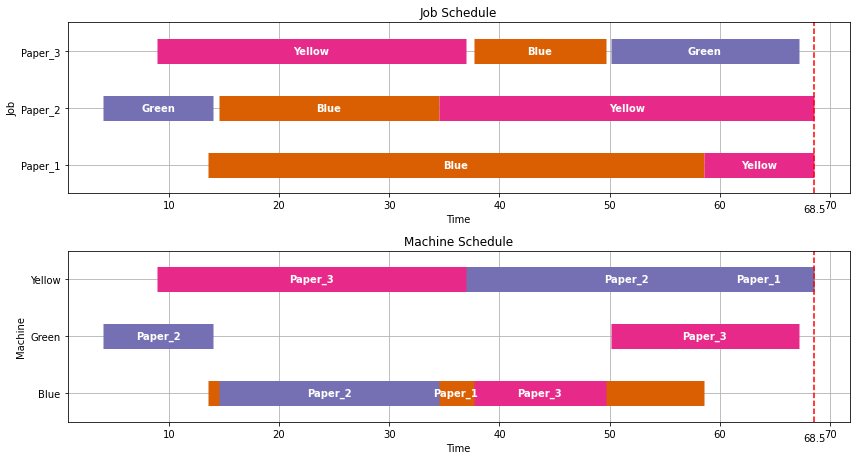

In [ ]:
def visualize(results):
    
    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

visualize(results)